In [34]:
import os
import numpy as np
from tqdm import tqdm
import json
import glob

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams["font.family"] = "Palatino"
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,10]})

from utils.rl_glue import RLGlue

In [35]:
def all_files_with_prefix_and_suffix(location, prefix, suffix):
    """returns a list of all files in the 'location' starting with the given prefix"""
    if location[-1] != '/':
        location += '/'
    files = glob.glob(location + prefix + '*' + suffix)

    return files

## A. Control experiments

In [36]:
### To run the experiments with RVI-Q and Diff-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AccessControl_diff-q.json --output-folder results/control/AccessControl
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AccessControl_rvi-q.json --output-folder results/control/AccessControl

### These use sample configuration files. Using them as is will result in LONG runtimes. 
### Try a single hyperparameter configuration, or split them the grid of configurations 
### appropriately for the compute resources available

In [82]:
def parse_data_ac(filename_prefix, item='rewards_all', metric='avg_reward', location='../results/', param1='alpha', param2='eta',
               title=None, lastn=-1, num_sa=None, logbase=-1, ylabel=None):
    """
    -'filename_prefix' should be the exp_name used in config.
    -leave 'item' as rewards_all for our experiments, set 'metric' to winloss to plot
       the winloss ratio instead of average reward
    - plot will be saved as 'title'.png, but it won't overwrite existing plots
    - You'll have to manually change  plt.ylim(0, 1), the y-limits to get nice looking plots
    - it just averages
    """

    files = all_files_with_prefix_and_suffix(location, filename_prefix, '*.npy')
    data_all = {}
    assert len(files) > 0, 'No files found with the prefix: ' + location + filename_prefix
    print(f'{"Filename":<10}{param1:<20}{param2:<10}{"Mean":<10}{"Std. error":<10}')
    for file in files:
        data = np.load(file, allow_pickle=True).item()
        param1_value = data['params']['agent_parameters'][param1]
        if param1_value not in data_all:
            data_all[param1_value] = {}
        param2_value = data['params']['agent_parameters'][param2] if param2!='dummy' else -1
        if param2_value not in data_all[param1_value]:
            data_all[param1_value][param2_value] = {}
        if metric == 'winloss':
            # item must be rewards_all for catcher
            wins = np.sum(data[item][:,1:lastn] == 1) #recall data starts at index 1 (timestep 1)
            losses = np.sum(data[item][:,1:lastn] == -1)
            winloss_ratio = wins / losses
            data_all[param1_value][param2_value] = (winloss_ratio, 0)
        elif metric == "avg_reward":
            data_to_eval = data[item][:,1:lastn] #recall data starts at index 1 (timestep 1)
            mean = np.mean(data_to_eval)
            stderr = np.std(data_to_eval) / np.sqrt(data_to_eval.size)
            data_all[param1_value][param2_value] = (mean, stderr)
        else:
            raise IllegalArgumentException()
        data_to_eval = data[item][:,1:lastn] #recall data starts at index 1 (timestep 1)
        mean = np.mean(data_to_eval)
        stderr = np.std(data_to_eval) / np.sqrt(data_to_eval.size)
        print(f'{file[-6:-4]:<10s}{param1_value:<20.6g}{param2_value:<10.6g}{mean:<12.6g}{stderr:<10.6g}')
    # X keys are param2, values are another dict with keys param1 and values the item arrays
    X = sorted(data_all)
    # weird way of getting sorted list of the param2 values
    Y = sorted(data_all[np.random.choice(list(data_all.keys()))]) 
    Z_mean = np.zeros((len(X), len(Y)))
    Z_stderr = np.zeros((len(X), len(Y)))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            try:
                Z_mean[i][j] = data_all[x][y][0]
                Z_stderr[i][j] = data_all[x][y][1]
            except:
                Z_mean[i][j] = np.nan
                Z_stderr[i][j] = np.nan

    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))
    for i, param_value in enumerate(X):
        ax.plot(Y, Z_mean[i], label=param1+'='+str(param_value))#, color='color')
    ax.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

    plt.ylim(-40, -5)
    if logbase != -1:
        plt.xscale('log', base=logbase)
    ax.set_xticks(Y)
    ax.set_xticklabels(Y)

    fig.tight_layout()
    path = location + title + '.png'
    if not os.path.isfile(path):
        plt.savefig(path)
    plt.show()

Filename  eta                 alpha     Mean      Std. error
-1        1                   0.01      -11.7068    0.0123238 
01        0.01                0.01      -9.18647    0.0110293 
-1        1                   0.001     -10.2564    0.0116547 
-1        1                   0.0001    -28.1783    0.0145503 
10        10                  0.0001    -29.9775    0.0149596 
.1        0.1                 0.1       -32.3213    0.0142057 
10        10                  0.1       -35.1102    0.01494   
10        10                  0.01      -13.3521    0.0127215 
01        0.01                0.0001    -27.0671    0.0156897 
.1        0.1                 0.001     -9.262      0.0110288 
.1        0.1                 0.01      -10.1157    0.0113386 
01        0.01                0.1       -32.7902    0.0143642 
-1        1                   0.1       -34.5947    0.0145728 
.1        0.1                 0.0001    -25.7394    0.0149087 
01        0.01                0.001     -7.82113    0.010

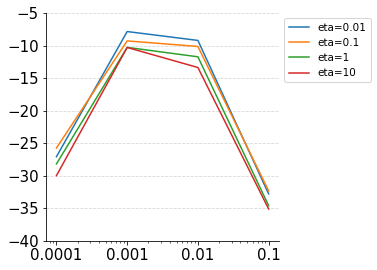

In [83]:
parse_data_ac('PuckWorld_DifferentialQlearningAgent', item='rewards_all', metric='avg_reward', param1='eta', param2='alpha',
               title='AC_DiffQ_eps_0.1_sensitivity', location='./results/PuckWorld_DifferentialQlearningAgent',
               lastn=-1, logbase=10, ylabel='Average\nreward\nover\ntraining')

In [15]:
!ls results

Catcher_DifferentialQlearningAgent  PuckWorld_DifferentialQlearningAgent
Catcher_RLearningAgent		    PuckWorld_RLearningAgent
Catcher_RVIQLearningAgent	    PuckWorld_RVIQLearningAgent
control				    sorted.zip


In [26]:
def plot_learning_curve_control_avg_reward(filenames, param1, param2, location='./results/', window=1000, sample=1, firstn=-1,
                                      title=None):
    """
    - For each file:
    - For each run: Compute a moving average of window length 'window' of the rewards
    - Compute mean of moving averages over all runs
    - Compute stderr of moving averages over all runs
    - plot every 'sample'th value of mean and stderr
    # TODO might want to plot win/loss ratio instead of reward for catcher
    - save the plot as 'title'.png, but don't overwrite existing ones
    """

    plt.figure(figsize=(8, 5))
    for filename in filenames:
        data = np.load(location + filename, allow_pickle=True).item()
        if not (param1 is None or param2 is None):
            p1 =data['params']['agent_parameters'][param1]
            p2 =data['params']['agent_parameters'][param2]
            plot_name = f'{param1}_{p1}_{param2}_{p2}'
        rewards_train = data['rewards_all'][:,1:firstn]
        max_run_length = rewards_train.shape[1] - 1 # time_steps start at 1, index reward by time_step
        conv_arr = np.ones(window)
        reward_rate_all = []
        # ToDo: figure out a way to vectorize this
        for run in range(rewards_train.shape[0]):
            reward_rate = np.convolve(rewards_train[run,:], conv_arr, mode='valid') / window
            reward_rate_all.append(reward_rate)
        reward_rate_all = np.array(reward_rate_all)
        mean = np.mean(reward_rate_all, axis=0)
        stderr = np.std(reward_rate_all, axis=0) / np.sqrt(reward_rate_all.shape[0])
        print(reward_rate_all.shape)
        x_s = np.arange(window, max_run_length+1)[::sample]
        y_s = mean[::sample]
        stderr_s = stderr[::sample]
        plt.plot(x_s, y_s, label=plot_name)
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3)

    # plt.axhline(y=1.69, color='black', alpha=0.5, linestyle='--')
    plt.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
    path = location + title + '.png'
    if not os.path.isfile(path):
        plt.savefig(path, dpi=1200)
    plt.show()

In [60]:
!ls results/control/catcher

Catcher_Diffq_10mil_0_model_params.pt
Catcher_Diffq_10mil_0.npy
Catcher_DiffQ_eps_1-0.1_0_model_params.pt
Catcher_DiffQ_eps_1-0.1_0.npy
Catcher_DiffQ_eps_1-0.1_sweep_0_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_0.npy
Catcher_DiffQ_eps_1-0.1_sweep_10_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_10.npy
Catcher_DiffQ_eps_1-0.1_sweep_11_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_11.npy
Catcher_DiffQ_eps_1-0.1_sweep_12_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_12.npy
Catcher_DiffQ_eps_1-0.1_sweep_13_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_13.npy
Catcher_DiffQ_eps_1-0.1_sweep_14_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_14.npy
Catcher_DiffQ_eps_1-0.1_sweep_15_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_15.npy
Catcher_DiffQ_eps_1-0.1_sweep_1_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_1.npy
Catcher_DiffQ_eps_1-0.1_sweep_2_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_2.npy
Catcher_DiffQ_eps_1-0.1_sweep_3_model_params.pt
Catcher_DiffQ_eps_1-0.1_sweep_3.npy
Catcher_Diff

(1, 996000)


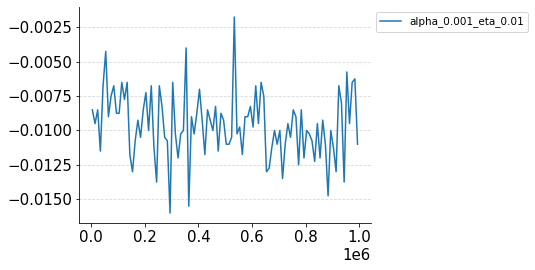

In [68]:
# best, best
### These filenames will be according to how the hyperparameter configurations are split
### for the available compute resources.
filenames = ['Catcher_Diffq_10mil_0.npy']
    
plot_learning_curve_control_avg_reward(filenames, param1='alpha', param2='eta', title='lc_plot_test', window=4000,
                            sample=10000, firstn=-1, location='./results/control/catcher/')

(30, 29500)
(30, 29500)
(30, 29500)
(30, 29500)
(30, 29500)
(30, 29500)
(30, 29500)
(30, 29500)


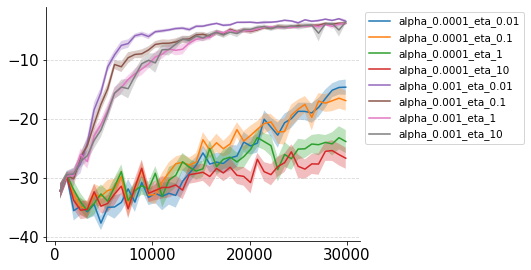

In [50]:
# best, best
### These filenames will be according to how the hyperparameter configurations are split
### for the available compute resources.
filenames = [
  'PuckWorld_DifferentialQlearningAgent_alpha-0.0001_eta-0.01.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.0001_eta-0.1.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.0001_eta-1.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.0001_eta-10.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.001_eta-0.01.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.001_eta-0.1.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.001_eta-1.npy',  
  'PuckWorld_DifferentialQlearningAgent_alpha-0.001_eta-10.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.01_eta-0.01.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.01_eta-0.1.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.01_eta-1.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.01_eta-10.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.1_eta-0.01.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.1_eta-0.1.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.1_eta-1.npy',  
#   'PuckWorld_DifferentialQlearningAgent_alpha-0.1_eta-10.npy'
    ]
    
plot_learning_curve_control_avg_reward(filenames, param1='alpha', param2='eta', title='lc_plot_test', window=500,
                            sample=700, firstn=-1, location='./results/PuckWorld_DifferentialQlearningAgent/')

(30, 77300)
(30, 77300)
(30, 77300)
(30, 77300)


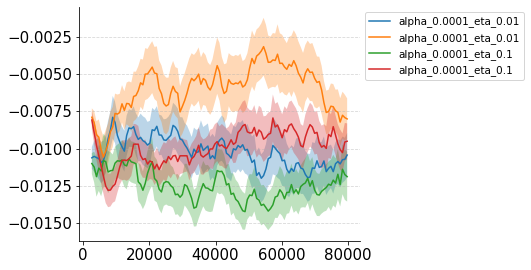

In [54]:
# best, best
### These filenames will be according to how the hyperparameter configurations are split
### for the available compute resources.
filenames = [
'Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-0.01_DUPLICATE.npy',
'Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-0.01.npy',
 'Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-0.1_DUPLICATE.npy',
 'Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-0.1.npy'
# Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-10_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-10.npy
# Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.0001_eta-1.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-0.01_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-0.01.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-0.1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-0.1.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-10_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-10.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.001_eta-1.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-0.01_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-0.01.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-0.1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-0.1.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-10_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-10.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.01_eta-1.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-0.01_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-0.01.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-0.1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-0.1.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-10_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-10.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-1_DUPLICATE.npy
# Catcher_DifferentialQlearningAgent_alpha-0.1_eta-1.npy
    ]
    
plot_learning_curve_control_avg_reward(filenames, param1='alpha', param2='eta', title='lc_plot_test', window=2700,
                            sample=700, firstn=-1, location='./results/Catcher_DifferentialQlearningAgent/')

In [66]:
def plot_learning_curve_control_winloss(filenames, location='./results/', window=1000, sample=1, firstn=-1,
                                      title=None):
    """
    - WIN/LOSS ratio for catcher
    - For each file:
    - For each run: Compute a moving average of window length 'window' of the win/loss rate
    - Compute mean of moving averages over all runs
    - Compute stderr of moving averages over all runs
    - plot every 'sample'th value of mean and stderr
    - save the plot as 'title'.png, but don't overwrite existing ones
    """

    plt.figure(figsize=(5.5, 4))
    which_step_size = 'alpha'
    for filename in filenames:
        data = np.load(location + filename, allow_pickle=True).item()
        rewards_train = data['rewards_all'][:,1:firstn]
        max_run_length = rewards_train.shape[1] - 1 # time_steps start at 1, index reward by time_step
        conv_arr = np.ones(window)
        
        wins_all = np.where(rewards_train == 1, 1, 0)
        losses_all = np.where(rewards_train == -1, 1, 0)
        winloss_rate_all = []
        for run in range(rewards_train.shape[0]):
            wins = np.convolve(wins_all[run,:], conv_arr, mode='valid')
            losses = np.convolve(losses_all[run,:], conv_arr, mode='valid')
            winloss_rate = wins / losses
            winloss_rate_all.append(winloss_rate)
        winloss_rate_all = np.array(winloss_rate_all)
        mean = np.mean(winloss_rate_all, axis=0)
        stderr = np.std(winloss_rate_all, axis=0) / np.sqrt(winloss_rate_all.shape[0])
        print(winloss_rate_all.shape)
        x_s = np.arange(window, max_run_length+1)[::sample]
        y_s = mean[::sample]
        stderr_s = stderr[::sample]
        agent_name = data['params']['agent']
        plt.plot(x_s, y_s, label=agent_name)
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3)

    # plt.axhline(y=1.69, color='black', alpha=0.5, linestyle='--')
    plt.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
    path = location + title + '.png'
    if not os.path.isfile(path):
        plt.savefig(path, dpi=1200)
    plt.show()

(30, 76000)
(30, 76000)


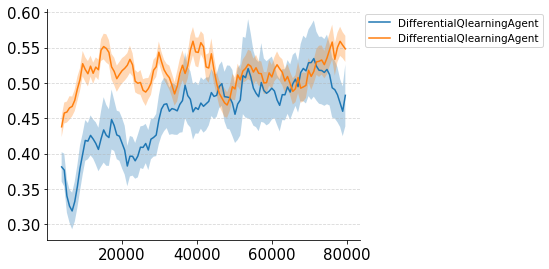

In [67]:
# best, best
### These filenames will be according to how the hyperparameter configurations are split
### for the available compute resources.
filenames = [
        "Catcher_DiffQ_eps_1-0.1_sweep_5.npy", 
        "Catcher_DiffQ_eps_1-0.1_sweep_3.npy",
    ]
    
plot_learning_curve_control_winloss(filenames, title='lc_plot_test', window=4000,
                            sample=700, firstn=-1, location='./results/control/catcher/')